In [ ]:
%load_ext tensorboard

In [1]:
#Modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from category_encoders import OneHotEncoder

import datetime

import pickle

In [2]:
#constant
datapath="../Data/Data Final/"

log_dir = "../logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

batch_size=32

In [3]:
#read df
df=pd.read_csv(datapath+"oversampled.csv")

X=df.copy()
y=X.pop("Kejadian")

In [4]:
onehotencoder=OneHotEncoder(cols=["KELURAHAN"])
onehotencoder.fit(X)
Xencoded=onehotencoder.transform(X)

#save onehot encoder
with open("../assets/onehotencoder.pkl", "bw") as fh:  
    data = onehotencoder
    pickle.dump(data, fh)

In [5]:
#train test split
train_data, test_data, train_value, test_value = train_test_split(Xencoded, y, train_size= 0.8)

## Model Testing

In [6]:
def thecallback():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]

def theplot(history):
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(2,1,1)
    ax.plot(history.history["binary_accuracy"], label="binary_accuracy", c="blue")
    ax.plot(history.history["val_binary_accuracy"], label="val_binary_accuracy", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("accuracy")
    ax.legend(loc="lower right")
    ax=fig.add_subplot(2,1,2)
    ax.plot(history.history["loss"], label="loss", c="blue")
    ax.plot(history.history["val_loss"], label="val_loss", c="orange")
    ax.legend(loc="lower right")
    ax.set_ylim(0,1)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")

In [7]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(16, activation='relu', input_dim=55),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), metrics=[keras.metrics.binary_accuracy])
  return model

In [8]:
epoch=100
test1=build_and_compile_model()
test1.fit(train_data, train_value, epochs=epoch, batch_size=batch_size,
          validation_data=(test_data, test_value),
          verbose=1, callbacks=thecallback())

Epoch 1/100
40/40 [==============================] - 2s 11ms/step - loss: 13.0204 - binary_accuracy: 0.4684 - val_loss: 2.7063 - val_binary_accuracy: 0.5443
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 1.2775 - binary_accuracy: 0.5767 - val_loss: 0.6945 - val_binary_accuracy: 0.7310
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.5961 - binary_accuracy: 0.7468 - val_loss: 0.5646 - val_binary_accuracy: 0.7247
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.5030 - binary_accuracy: 0.7468 - val_loss: 0.5246 - val_binary_accuracy: 0.7373
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4654 - binary_accuracy: 0.7674 - val_loss: 0.4908 - val_binary_accuracy: 0.7405
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4462 - binary_accuracy: 0.7816 - val_loss: 0.4687 - val_binary_accuracy: 0.7468
Epoch 7/100
40/40 [==============================] - 0s 7ms/step - l

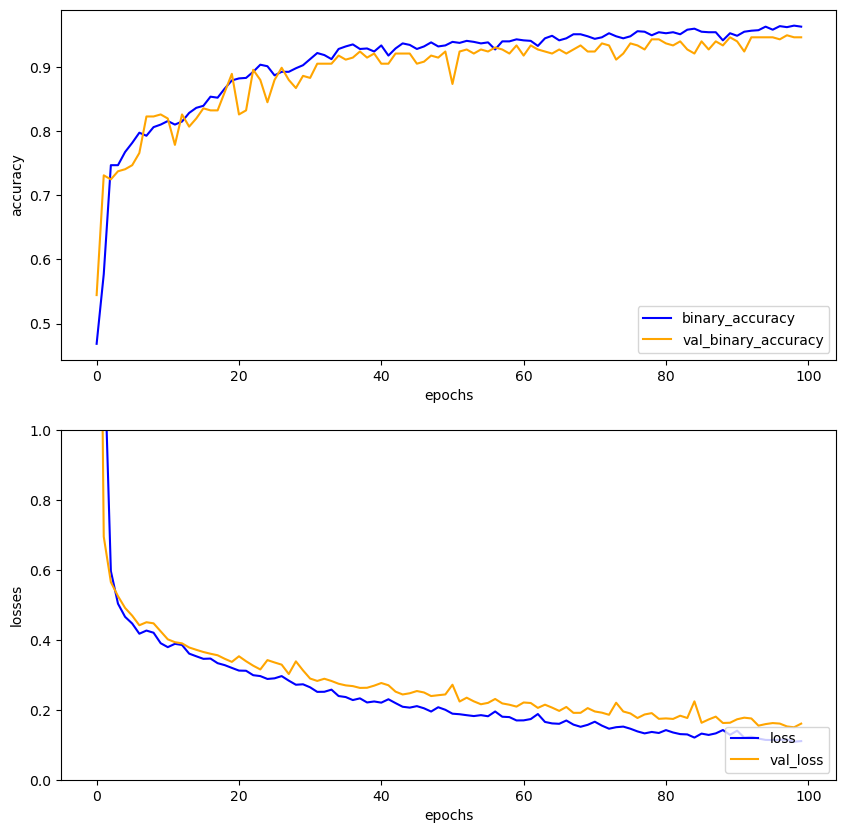

In [9]:
theplot(test1.history)

In [7]:
#for predict later 
def predict(model, features):
    predicted=model.predict(features)
    predicted = tf.where(predicted < 0.5, 0, 1)
    return np.array(predicted).flatten()


predicted=predict(test1, train_data)

NameError: name 'test1' is not defined

## Tuning

In [35]:
import keras_tuner as kt

#making the model

def getmodel(hp):
  model = keras.Sequential()
  
  #1st layer
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)            #Finding the best layer
  model.add(keras.layers.Dense(hp_units, activation='relu', input_dim=55))
  
  
  #output layer
  model.add(keras.layers.Dense(1, activation="sigmoid"))


  #learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  #Finding the best learning rate

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["binary_accuracy"])

  return model

In [36]:
#Running the hyperparamatere search
thetuner=kt.Hyperband(getmodel, objective="val_binary_accuracy",                       #Finding the best val_accuracy of the brute!
                      max_epochs=30,
                      factor=2,
                      directory='Test1',  
                      project_name='test1')

In [37]:
thetuner.search(train_data, train_value, epochs=100, validation_data=(test_data, test_value))               #almost the same as keras.model.sequential.fit


best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 82 Complete [00h 00m 05s]
val_binary_accuracy: 0.892405092716217

Best val_binary_accuracy So Far: 0.9620253443717957
Total elapsed time: 00h 02m 58s


In [40]:
#Built a model with the most optimal hyperparameters
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(train_data, train_value, epochs=100, validation_data=(test_data, test_value))

Epoch 1/100
40/40 [==============================] - 1s 8ms/step - loss: 2.8613 - binary_accuracy: 0.6313 - val_loss: 0.6521 - val_binary_accuracy: 0.8070
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.4456 - binary_accuracy: 0.8133 - val_loss: 0.3167 - val_binary_accuracy: 0.8703
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3067 - binary_accuracy: 0.8663 - val_loss: 0.2975 - val_binary_accuracy: 0.8861
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.2992 - binary_accuracy: 0.8679 - val_loss: 0.2670 - val_binary_accuracy: 0.9019
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2489 - binary_accuracy: 0.8964 - val_loss: 0.2736 - val_binary_accuracy: 0.8924
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2343 - binary_accuracy: 0.9161 - val_loss: 0.3585 - val_binary_accuracy: 0.7975
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - los

In [41]:
#get the best epoch
val_acc_per_epoch = process.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#Yeee!111

Best epoch: 76


In [44]:
model.save("../assets/model.keras")